In [1]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/')
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/.ipynb_checkpoints')
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import io_utils as io
import operators as op
import qgutils as qg
import xarray as xr
import scipy as sp

## Charging the parameters of the simulation

In [108]:
#Number of simulation
n=39



#Reading the netcdf file
if n<10:
    simu_name='outdir_000'+str(n)
elif n<100 and n>=10:
    simu_name='outdir_00'+str(n)
print(simu_name)
Path='/home/massoale/Simu_Test/qgw-main/src/'
filenames=[simu_name+'/vars.nc']
# Importing the netCDF4 module
# Open the netcdf file
dataset=nc.Dataset(Path+filenames[0])
print(dataset.variables.keys())

t=dataset.variables['time'][:]
x=dataset.variables['x'][:]
y=dataset.variables['y'][:]
psi=dataset.variables['psi'][:,:,:,:]
q=dataset.variables['q'][:,:,:,:]
print("psi shape",psi.shape)


outdir_0039
dict_keys(['time', 'y', 'x', 'level', 'psi', 'q'])
psi shape (339, 1, 256, 256)


In [109]:
ds = xr.open_dataset(Path+filenames[0])
ds

<xarray.Dataset> Size: 178MB
Dimensions:  (time: 339, y: 256, x: 256, level: 1)
Coordinates:
  * time     (time) float32 1kB 0.0 10.0 20.0 ... 3.36e+03 3.37e+03 3.38e+03
  * y        (y) float32 1kB 0.0 0.02454 0.04909 0.07363 ... 6.21 6.234 6.259
  * x        (x) float32 1kB 0.0 0.02454 0.04909 0.07363 ... 6.21 6.234 6.259
  * level    (level) float32 4B 0.0
Data variables:
    psi      (time, level, y, x) float32 89MB ...
    q        (time, level, y, x) float32 89MB ...

In [110]:
#Lecture des paramètres :

param=io.read_params(Path+simu_name)
print(param)
f0= param['f0']
beta=param['beta']
hEkb=param['hEkb']
dh=param['dh'][0]
Lx=param['Lx']
nx=param['NX']
ny=param['NY']
k_f=param['k_f']
sigma_f=param['sigma_f']
bc_fac=param['bc_fac']
nu_hyper=param['nu_hyper']
n_hyper=param['n_hyper']
dt_out=param['dt_out']


print("we get one output every ",dt_out,"s")

{'NX': 256.0, 'NY': 256.0, 'nl': 1.0, 'Lx': 6.283185307179586, 'f0': 2.0, 'beta': 4.0, 'k_f': 32.0, 'sigma_f': 0.002, 'bc_fac': -1.0, 'dh': array([1.]), 'N2': array([0.]), 'nu': 0.0, 'nu_hyper': 9e-13, 'n_hyper': 6.0, 'hEkb': 0.0005, 'tend': 1576800000000.0, 'dt_out': 10.0}
we get one output every  10.0 s


In [111]:
#computing u and v from psi
delta=Lx/nx
u,v=op.calc_uv(psi[:,0,:,:],delta,bc_fac)
energy=0.5*(u**2+v**2)


# Looking at the energy at the end of the simu

Text(0.5, 1.0, 'Kinetic energy of the last 100 seconds outdir_0039')

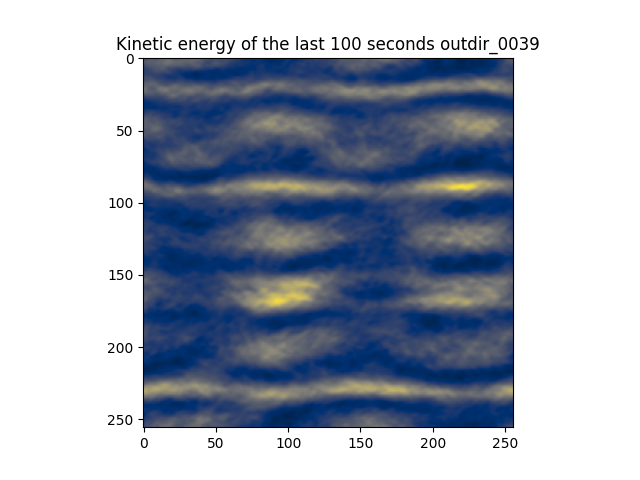

In [122]:
plt.figure()
plt.imshow(np.mean(energy[-10:-1,:,:],axis=0),cmap='cividis')
plt.title('Kinetic energy of the last 100 seconds '+simu_name)

## Making a fourier transform of the psi data

/tmp/ipykernel_175663/3862551443.py:38: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(energy_spectrum ), extent=(-np.max(kx), np.max(kx), -np.max(ky), np.max(ky)), cmap='hot', origin='lower',vmin=0,vmax=10)


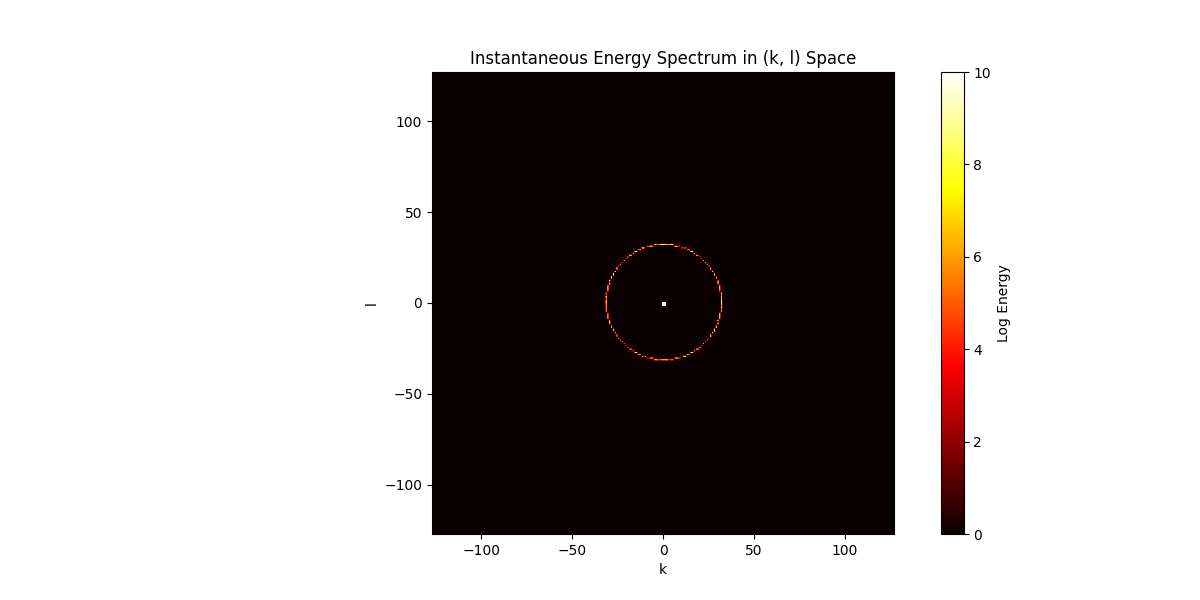

In [6]:

#Making a fourier series of the data:


#Selecting the indice corresponding to the time
time_sel=1
psi_data=psi[time_sel,0,:,:]


# 2D Fourier Transform
fft_result = np.fft.fft2(psi_data)
fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency component to center
n = psi_data.shape[0]
dx=Lx/nx/(2*np.pi)
dy=Lx/ny/(2*np.pi)

kx=np.fft.fftfreq(int(nx),d=dx)
ky=np.fft.fftfreq(int(ny),d=dy)
kx_reshaped=np.zeros_like(kx)
kx_reshaped[0:len(kx)//2]=kx[len(kx)//2:]
kx_reshaped[len(kx)//2:]=kx[0:len(kx)//2]

ky_reshaped=np.zeros_like(ky)
ky_reshaped[0:len(ky)//2]=ky[len(ky)//2:]
ky_reshaped[len(ky)//2:]=ky[0:len(ky)//2]

Kx,Ky=np.meshgrid(kx_reshaped,ky_reshaped)
Ky=np.flipud(Ky)
k_norm=np.sqrt(Kx**2+Ky**2)

# 2D Fourier Transform
fft_result = np.fft.fft2(psi_data[:,:])
fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency component to center
epsilon = 1e-10  # Small value to avoid log(0)
#Calculating Energy
energy_spectrum = np.abs(fft_shifted) ** 2 * k_norm**2
# Step 3: Plot the Spectrum
plt.figure(figsize=(12, 6))
plt.imshow(np.log(energy_spectrum ), extent=(-np.max(kx), np.max(kx), -np.max(ky), np.max(ky)), cmap='hot', origin='lower',vmin=0,vmax=10)


plt.colorbar(label='Log Energy')
plt.xlabel('k')
plt.ylabel('l')
plt.title('Instantaneous Energy Spectrum in (k, l) Space')
plt.show()


" Considering the averaged energy spectrum over a few snapshots

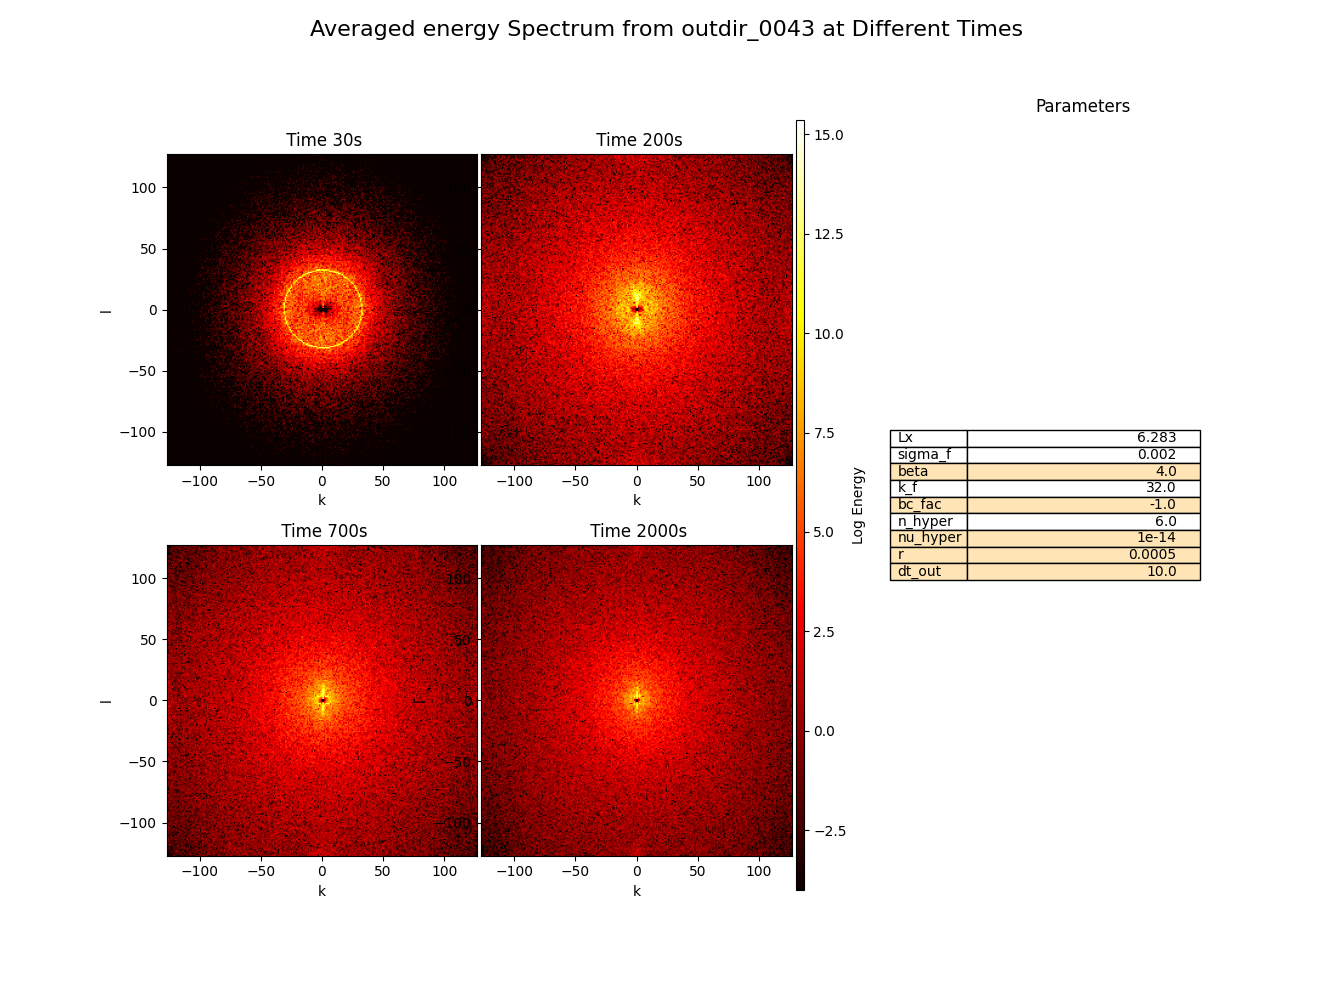

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the times to visualize
times_to_plot = [3, 20,70,200]

# Convertir Lx en float avec 3 décimales
Lx_formatted = "{:.3f}".format(Lx)

ratio=5/6
# Création de la figure
fig = plt.figure(figsize=(16*ratio, 12*ratio))

# Grid spec pour diviser la figure en sections
grid = fig.add_gridspec(nrows=2, ncols=5, width_ratios=[4,4,0.1,2,3],hspace=0.03,wspace=0.02)


dx=Lx/nx/(2*np.pi)
dy=Lx/ny/(2*np.pi)

kx=np.fft.fftfreq(int(nx),d=dx)
ky=np.fft.fftfreq(int(ny),d=dy)
kx_reshaped=np.zeros_like(kx)
kx_reshaped[0:len(kx)//2]=kx[len(kx)//2:]
kx_reshaped[len(kx)//2:]=kx[0:len(kx)//2]

ky_reshaped=np.zeros_like(ky)
ky_reshaped[0:len(ky)//2]=ky[len(ky)//2:]
ky_reshaped[len(ky)//2:]=ky[0:len(ky)//2]

Kx,Ky=np.meshgrid(kx_reshaped,ky_reshaped)
Ky=np.flipud(Ky)
k_norm=np.sqrt(Kx**2+Ky**2)



# Loop through each time and plot the corresponding image
for idx, time_sel in enumerate(times_to_plot):
    # Average psi over 5 time steps
    psi_avg = np.mean(psi[time_sel:time_sel+5], axis=0)
    
    # 2D Fourier Transform
    fft_result = np.fft.fft2(psi_avg[0,:,:])
    fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency component to center
    epsilon = 1e-10  # Small value to avoid log(0)
    #Calculating Energy
    energy_spectrum = np.abs(fft_shifted) ** 2 * k_norm**2
    #Plotting the Spectrum
    ax = fig.add_subplot(grid[idx // 2, idx % 2])
    img=ax.imshow(np.log(energy_spectrum+epsilon), extent=(-np.max(kx), np.max(kx), -np.max(ky), np.max(ky)), cmap='hot', origin='lower',vmin=-4)
    ax.set_xlabel('k')
    ax.set_ylabel('l')
    ax.set_title(f' Time {time_sel*10}'+ 's')


ax2=fig.add_subplot(grid[:, 2])

cbar = plt.colorbar(img, cax=ax2)
cbar.set_label('Log Energy')


# Tableau des paramètres sur la droite
param_table = fig.add_subplot(grid[:, 4])
param_table.axis('off')  # Pour enlever les axes

r=f0*hEkb/(dh*2)
colors2D = [['white'] for _ in range(2)] + [['moccasin']] + [['white']] + [['moccasin']] + [['white']] + [['moccasin'] for _ in range(3)]
colors = ['white' for _ in range(2) ] + ['moccasin'] + ['white'] + ['moccasin'] + ['white'] + ['moccasin' for _ in range(3) ]

param_table.table(cellText=[[Lx_formatted], [sigma_f],[beta] , [k_f], [bc_fac], [n_hyper], [nu_hyper], [r] ,[dt_out]],
                  rowLabels=['Lx','sigma_f','beta', 'k_f', 'bc_fac', 'n_hyper', 'nu_hyper', 'r', 'dt_out'],
                  loc='center' ,cellColours=colors2D,rowColours=colors)
param_table.set_title('Parameters')

plt.subplots_adjust(wspace=0.5)  # Adjust horizontal spacing
plt.suptitle('Averaged energy Spectrum from '+str(simu_name)+' at Different Times', fontsize=16)
#plt.tight_layout()
plt.savefig('./figures/Energy_Spectrum_'+str(simu_name)+'.png')
plt.show()


<function matplotlib.pyplot.show(block=None)>

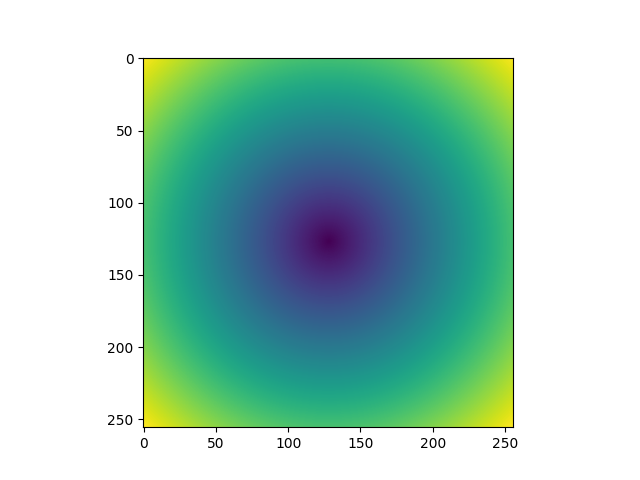

In [8]:
#plotting my k_norm matrix
plt.figure()
plt.imshow(k_norm)
plt.show

As time increases, the energy goes toward smaller wavenumbers and thus greater scales. There are more energy distributed along the y axis arround the k=0 emphasizing the presence of jets. 

/tmp/ipykernel_175663/571191728.py:9: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(energy_spectrum) , extent=(-np.pi, np.pi, -np.pi, np.pi), cmap='Greys', origin='lower')


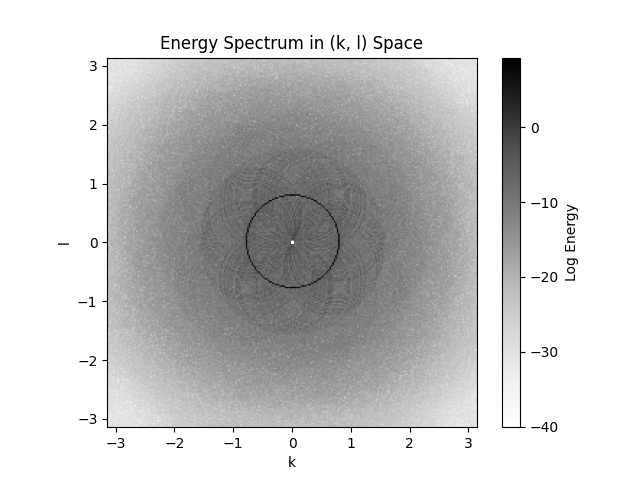

In [9]:
# Assuming ii[10,0,:,:]

fft_result = np.fft.fft2(psi_data)# Step 1: Fourier Transform
fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency component to center

energy_spectrum = np.abs(fft_shifted) ** 2* k_norm**2

plt.figure()
plt.imshow(np.log(energy_spectrum) , extent=(-np.pi, np.pi, -np.pi, np.pi), cmap='Greys', origin='lower')


plt.colorbar(label='Log Energy')
plt.xlabel('k')
plt.ylabel('l')
plt.title('Energy Spectrum in (k, l) Space')
plt.show()



# Energy\Enstrophy checking
Using Lennard python tools to check things with the simu data

In [10]:
from diagnostics_pkg import operators as op


(390, 256, 256)


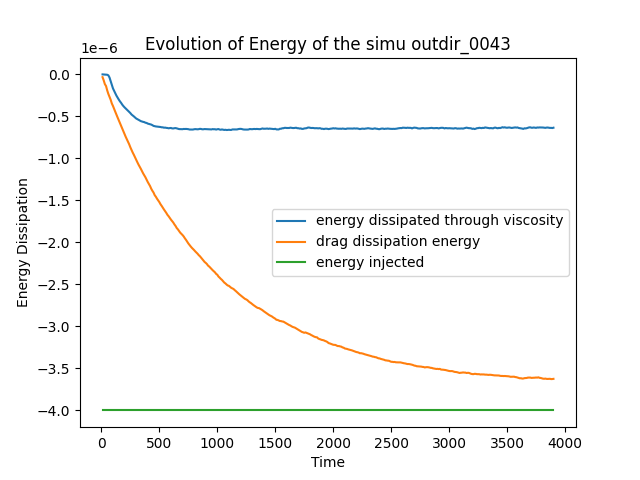

In [11]:

psi_data = psi[1:, 0, :, :]
q_data = q[1:, 0, :, :]

dx=x[-1]/x.shape[0]
dy=y[-1]/y.shape[0]
Lx=x[-1] #Lengh of the domain
Ly=y[-1] #Width of the domain

#Calculating the energy
energy_totale=op.calc_en(psi_data, q_data,dx,bc_fac=bc_fac)/Lx**2


enstro=op.calc_lap(psi_data,dx,bc_fac=bc_fac)**2/2
print(np.shape(enstro))
enstro_mean=np.mean(enstro,axis=(1,2))
#Calculating the total enstrophy for each snapshots
enstro_tot=np.sum(enstro,axis=(1,2))


dx=x[-1]/x.shape[0]
r=f0*hEkb/(dh*2)


#energy injectée :
energy_inj=np.zeros_like(energy_totale)
energy_inj[:]=sigma_f**2
energy_diss=-2*energy_totale*r
#enstro_diss=-2*nu_hyper*enstro_mean

#Calculating the enerrgy dissipated by hyper-viscosity
lap_vorticity=op.calc_lap(q_data,dx,bc_fac=bc_fac)
palenstro_tot=np.sum(lap_vorticity**2,axis=(1,2))/Lx**2
palenstro_tot=np.mean(lap_vorticity**2,axis=(1,2))
enstro_diss=-nu_hyper*palenstro_tot 
plt.figure()

plt.plot(t[1:],enstro_diss,label='energy dissipated through viscosity')
plt.plot(t[1:],energy_diss,label='drag dissipation energy')
plt.plot(t[1:],-energy_inj,label='energy injected')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Energy Dissipation')
plt.title('Evolution of Energy of the simu '+str(simu_name))
#plt.savefig('./figures/Energy_Dissipation_'+str(simu_name)+'.png')
plt.show()




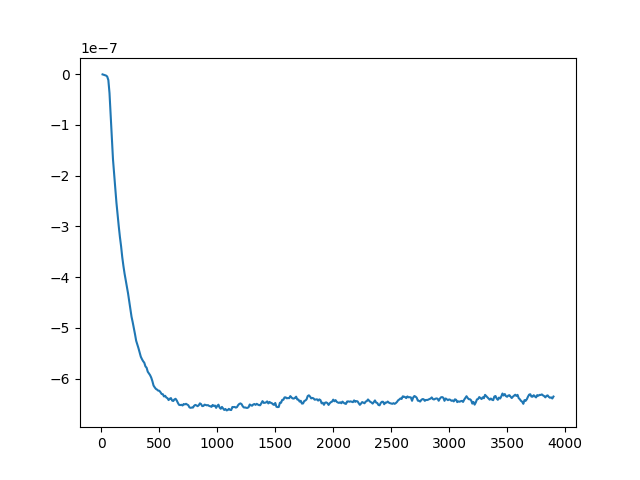

In [12]:
#Calculating the enerrgy dissipated by hyper-viscosity with n=6
lap_vorticity=op.calc_lap(q_data,dx,bc_fac=bc_fac)
palenstro_tot=np.sum(lap_vorticity**2,axis=(1,2))/Lx**2
palenstro_tot=np.mean(lap_vorticity**2,axis=(1,2))
enstro_diss=-nu_hyper*palenstro_tot 
plt.figure()
plt.plot(t[1:],enstro_diss)

In [13]:
3.6/4


0.9

# Energy cascade

/tmp/ipykernel_175663/3841158096.py:39: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(psd),extent=(np.min(kx), np.max(kx), np.min(ky), np.max(ky)), cmap='hot', origin='lower',vmin=4,vmax=10)


chargement de la frame 291
chargement de la frame 292
chargement de la frame 293
chargement de la frame 294
chargement de la frame 295


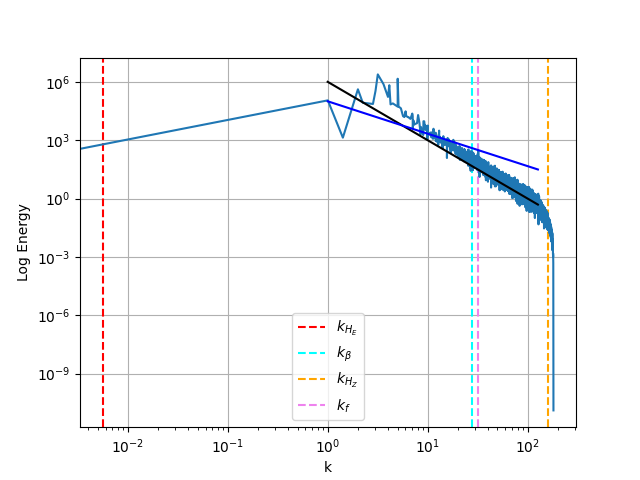

Text(0.5, 0.2, 'Parameters')

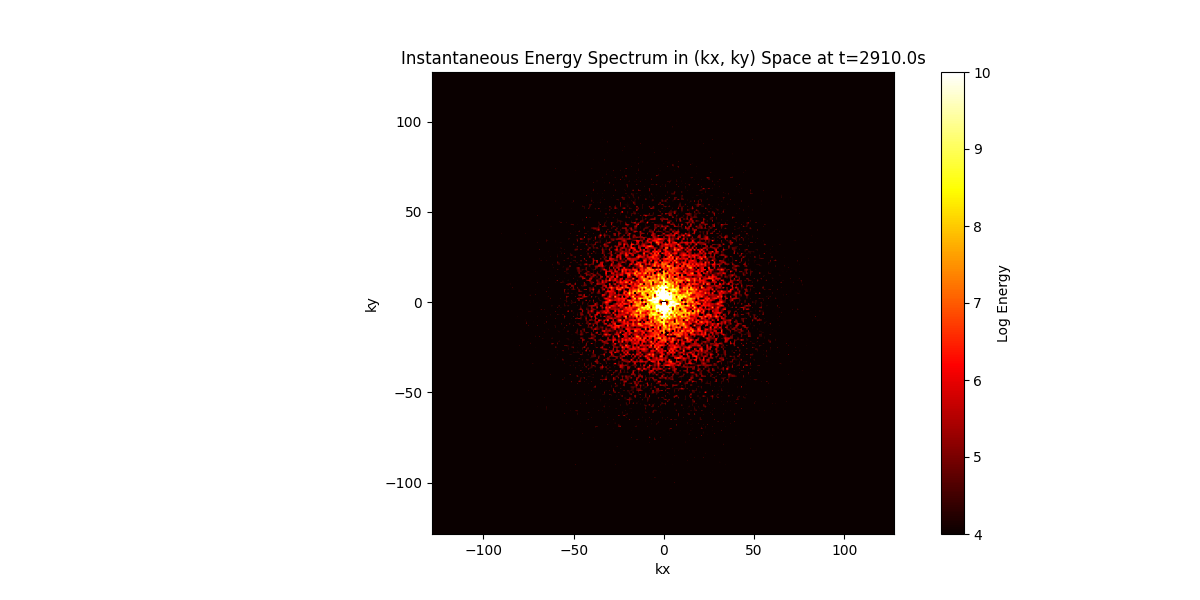

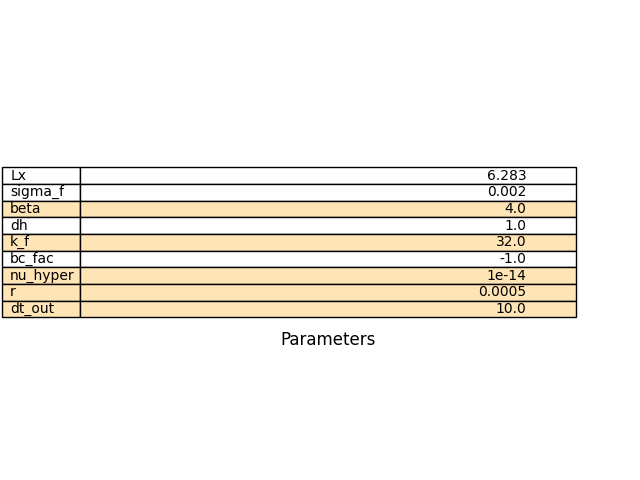

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Selecting the index corresponding to the time you want to visualize
time_sel = len(t)-100
averaging_over = 5  # Number of time steps to average over

k = np.arange(1.,nx//2)
epsilon=sigma_f**2
eta=k_f**2*epsilon

#Calculating the wavenumbers:
dx=Lx/nx/(2*np.pi)
dy=Ly/ny/(2*np.pi)

kx=np.fft.fftfreq(int(nx),d=dx)
ky=np.fft.fftfreq(int(ny),d=dy)
kx_reshaped=np.zeros_like(kx)
kx_reshaped[0:len(kx)//2]=kx[len(kx)//2:]
kx_reshaped[len(kx)//2:]=kx[0:len(kx)//2]

ky_reshaped=np.zeros_like(ky)
ky_reshaped[0:len(ky)//2]=ky[len(ky)//2:]
ky_reshaped[len(ky)//2:]=ky[0:len(ky)//2]

Kx,Ky=np.meshgrid(kx_reshaped,ky_reshaped)
Ky=np.flipud(Ky)
k_norm=np.sqrt(Kx**2+Ky**2)


# Get the power spectrum density
psi_fft = np.fft.fft2(psi[time_sel, 0, :, :])
psi_fft_shifted = np.fft.fftshift(psi_fft)
psd = np.abs(psi_fft_shifted)**2*k_norm**2


# Plot the 1D power spectrum density
plt.figure(figsize=(12, 6))
plt.imshow(np.log(psd),extent=(np.min(kx), np.max(kx), np.min(ky), np.max(ky)), cmap='hot', origin='lower',vmin=4,vmax=10)
plt.colorbar(label='Log Energy')
plt.xlabel('kx')
plt.ylabel('ky')
plt.title('Instantaneous Energy Spectrum in (kx, ky) Space at t='+str(t[time_sel])+'s')

psd_1d_avg=np.zeros_like(np.unique(k_norm))
i=0
for time in range(time_sel,time_sel+averaging_over):
    print("chargement de la frame",time)
    psi_data = psi[time, 0, :, :]


    psi_fft = np.fft.fft2(psi_data)
    psi_fft_shifted = np.fft.fftshift(psi_fft)
    psd = np.abs(psi_fft_shifted)**2#*k_norm**2
    psd_1d=np.zeros_like(np.unique(k_norm))
    k_values=np.sort(np.unique(k_norm))
   
                
    #Calculating 1d spectrum
    for idx, kx_v in enumerate(kx_reshaped):
        for idy, ky_v in enumerate(ky_reshaped):
            k_norm_v=np.sqrt(kx_v**2+ky_v**2)#Recalculating the norm of the wavenumber
            indice=np.where(k_values==k_norm_v)
            psd_1d[indice]+=psd[idx,idy]*k_norm_v
    psd_1d_avg+=psd_1d
    i+=1
psd_1d_avg=psd_1d_avg/(i)



#plotting the 1d spectrum

plt.figure()
r=f0*hEkb/(2*dh)
k_beta=(beta**3/epsilon)**(1/5)
kH_E=np.sqrt(r**3/epsilon)
kh_Z=(eta**(1/3)/(nu_hyper))**(1/n_hyper)
plt.axvline(x=kH_E, color='red', linestyle='--', label='$k_{H_E}$')
plt.axvline(x=k_beta, color='cyan', linestyle='--', label='$k_\\beta$')
plt.axvline(x=kh_Z, color='orange', linestyle='--', label='$k_{H_Z}$')
plt.axvline(x=k_f, color='violet', linestyle='--', label='$k_{f}$')
plt.loglog(k_values,psd_1d_avg)
plt.plot(k, 1e6 * k**(-3), color='k')
plt.plot(k, 1e5 * k**(-5/3), color='b')
plt.grid()

plt.xlabel('k')
plt.ylabel('Log Energy')
plt.legend()
plt.show()

#Adding a table with the parameters
fig=plt.figure()

# Tableau des paramètres sur la droite
param_table = fig.add_subplot(1,1,1)
param_table.axis('off')  # Pour enlever les axes

r=f0*hEkb/(dh*2)
colors2D = [['white'] for _ in range(2)] + [['moccasin']] + [['white']] + [['moccasin']] + [['white']] + [['moccasin'] for _ in range(3)]
colors = ['white' for _ in range(2) ] + ['moccasin'] + ['white'] + ['moccasin'] + ['white'] + ['moccasin' for _ in range(3) ]

param_table.table(cellText=[[Lx_formatted], [sigma_f],[beta], [dh] , [k_f], [bc_fac], [nu_hyper], [r] ,[dt_out]],
                  rowLabels=['Lx','sigma_f','beta', 'dh', 'k_f', 'bc_fac', 'nu_hyper', 'r', 'dt_out'],
                  loc='center' ,cellColours=colors2D,rowColours=colors)
param_table.set_title('Parameters',y=0.2)



## Energy Spectrum with Bruno code

391


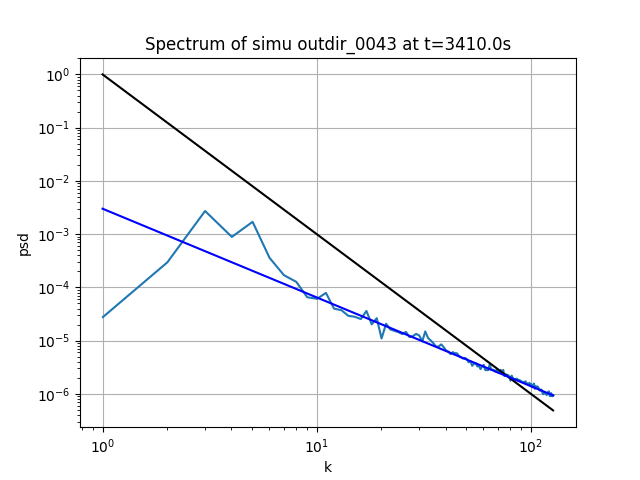

In [69]:
#Plotting the 1D spec using Bruno's code
time_sel=-50
averaging_over=30

psi_data = psi[time_sel, 0, :, :]
q_data = q[time_sel, 0, :, :]
kr, spec1d=qg.fftlib.get_spec_1D(psi_data, q_data, dx,window=None, all_kr= False, averaging='radial')

spec1d_avg=np.zeros_like(spec1d)
for time in range(time_sel,time_sel+averaging_over):
    psi_data = psi[time, 0, :, :]
    q_data = q[time, 0, :, :]
    kr, spec1d=qg.fftlib.get_spec_1D(psi_data, q_data, dx,window=None, all_kr= False, averaging='radial')
    spec1d_avg+=spec1d

spec1d_avg=spec1d_avg/averaging_over
print(len(t))
plt.figure()
plt.loglog(kr,np.abs(spec1d))
k = np.arange(1.,nx//2)
plt.plot(k, 1 * k**(-3), color='k')
plt.plot(k, 3e-3 * k**(-5/3), color='b')
plt.title('Spectrum of simu '+ str(simu_name)+' at t='+str(t[time_sel])+'s')
plt.xlabel('k')
plt.ylabel('psd')
plt.grid()

Text(0.5, 1.0, 'Kinetic Energy Spectrum of the simulation outdir_0043')

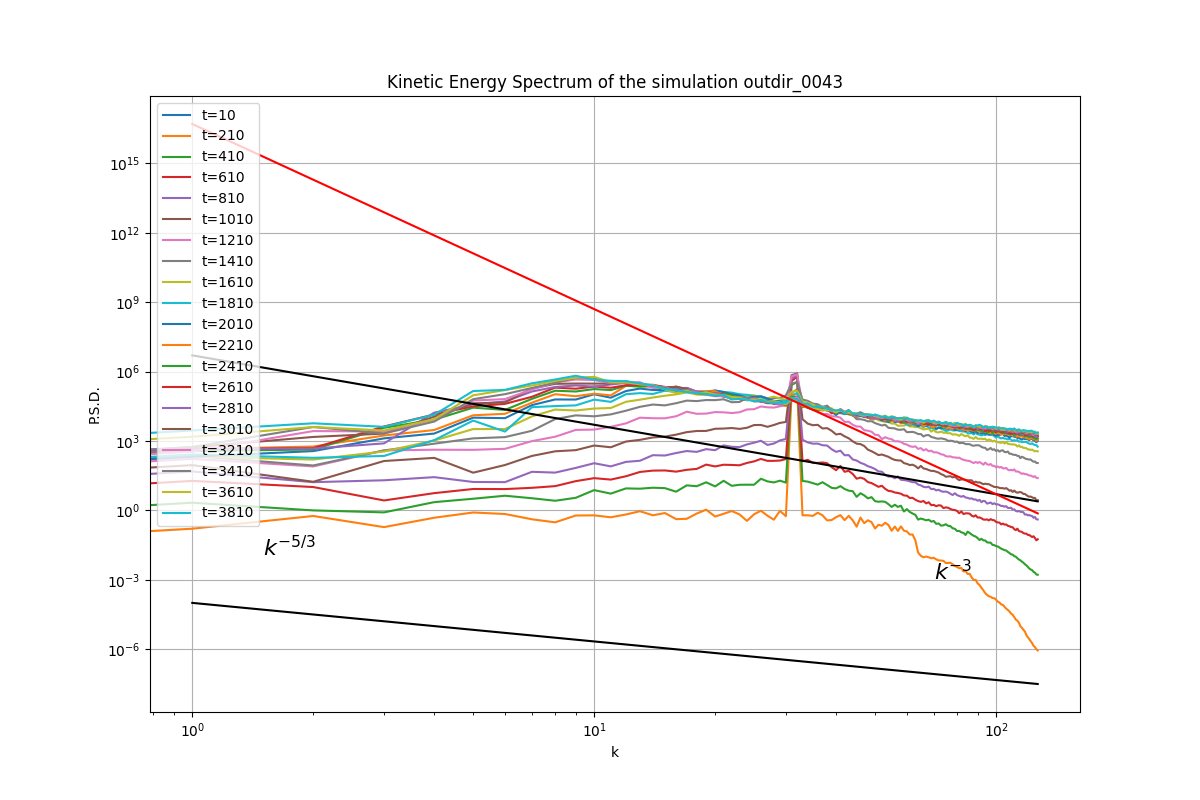

In [ ]:

psi_data = psi[:, 0, :, :]


def spec2d(nx, kk, phi, alpha=0):
    hphi = np.abs(np.fft.fft2(phi))**2

    if alpha>0:
        hphi *= kk**alpha
    spec = np.zeros((nx//2,))
    for i in range(nx//2):
        spec[i] = np.sum(hphi[(kk>=i) & (kk<(i+1))])
    return spec

def set_x_and_k(n, L):
    k = ((n//2+np.arange(n)) % n) - n//2
    return (np.arange(n)+0.5)*L/n, 2*np.pi*k/L

ny, nx = np.shape(psi_data[0])

_, kx = set_x_and_k(nx, 2*np.pi)
_, ky = set_x_and_k(ny, 2*np.pi)
kkx, kky = np.meshgrid(kx, ky)
kk = np.sqrt(kkx**2 + kky**2)




# let's plot the Kinetic Energy spectrum
# in Fourier space KE = k^2 |psi|^2 * 0.5

plt.figure(figsize=(12,8))

for k, time in enumerate(t[1::20]):
    
    h = spec2d(nx, kk, psi_data[k], alpha=2)
    plt.loglog(h, label='t=%.0f' % time)
#plt.axis([0.1, 100, 1e-3, 1e5])
plt.grid()
k = np.arange(1.,nx//2)
plt.plot(k, 5e6 * k**(-3), color='k')
plt.plot(k, 5e16 * k**(-8), color='r')
plt.plot(k, 1e-4 * k**(-5./3), color='k') # the coefficient set the vertical position of the line
plt.text(1.5, 0.01, r'$k^{-5/3}$', fontsize=16)
plt.text(70,0.001, r'$k^{-3}$', fontsize=16)
plt.legend()
plt.xlabel('k')
plt.ylabel('P.S.D.')
plt.title('Kinetic Energy Spectrum of the simulation '+str(simu_name))

/tmp/ipykernel_160029/381025719.py:110: RuntimeWarning: divide by zero encountered in power
  plot3, = plt.loglog(f, f**(-5/3)*P[1]/f[1]**(-5/3)*10**1,'--',color='k',linewidth=2)
/tmp/ipykernel_160029/381025719.py:111: RuntimeWarning: divide by zero encountered in power
  plot2, = plt.loglog(f, f**(-3)*P[1]/f[1]**(-3)*10**5,'-',color='k',linewidth=2)


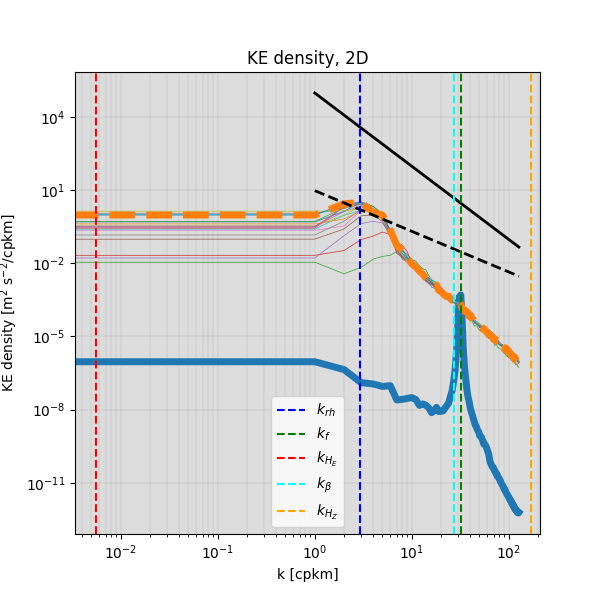

In [ ]:
from scipy import fftpack
# for 2d spectra
time_sel=-1

def azimuthalAverage(image, center=None, stddev=False, returnradii=False, return_nr=False,
        binsize=1, weights=None, steps=False, interpnan=False, left=None, right=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is
             None, which then uses the center of the image (including
             fractional pixels).
    stddev - if specified, return the azimuthal standard deviation instead of the average
    returnradii - if specified, return (radii_array,radial_profile)
    return_nr   - if specified, return number of pixels per radius *and* radius
    binsize - size of the averaging bin.  Can lead to strange results if
        non-binsize factors are used to specify the center and the binsize is
        too large
    weights - can do a weighted average instead of a simple average if this keyword parameter
        is set.  weights.shape must = image.shape.  weighted stddev is undefined, so don't
        set weights and stddev.
    steps - if specified, will return a double-length bin array and radial
        profile so you can plot a step-form radial profile (which more accurately
        represents what's going on)
    interpnan - Interpolate over NAN values, i.e. bins where there is no data?
        left,right - passed to interpnan; they set the extrapolated values

    If a bin contains NO DATA, it will have a NAN value because of the
    divide-by-sum-of-weights component.  I think this is a useful way to denote
    lack of data, but users let me know if an alternative is prefered...
   
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)
    if center is None:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
    r = np.hypot(x - center[0], y - center[1])
    if weights is None:
        weights = np.ones(image.shape)
    elif stddev:
        raise ValueError("Weighted standard deviation is not defined.")
    # the 'bins' as initially defined are lower/upper bounds for each bin
    # so that values will be in [lower,upper)  
    nbins = int((np.round(r.max() / binsize)+1))
    maxbin = nbins * binsize
    bins = np.linspace(0,maxbin,nbins+1)
    # but we're probably more interested in the bin centers than their left or right sides...
    bin_centers = (bins[1:]+bins[:-1])/2.0
    # Find out which radial bin each point in the map belongs to
    whichbin = np.digitize(r.flat,bins)
    # how many per bin (i.e., histogram)?
    # there are never any in bin 0, because the lowest index returned by digitize is 1
    nr = np.bincount(whichbin)[1:]
    # recall that bins are from 1 to nbins (which is expressed in array terms by arange(nbins)+1 or xrange(1,nbins+1) )
    # radial_prof.shape = bin_centers.shape
    if stddev:
        radial_prof = np.array([image.flat[whichbin==b].std() for b in range(1,nbins+1)])
    else:
        # add renormalization (2pi/k/n)
        #norm = np.array([weights.flat[whichbin==b].sum() for b in xrange(1,np.int(nbins)+1)])  
        #norm_k = np.array([2*np.pi*(b) for b in xrange(1,np.int(nbins)+1)])       
        radial_prof = np.array([(image*weights).flat[whichbin==b].sum() / weights.flat[whichbin==b].sum() * 2*np.pi*b for b in range(1,int(nbins)+1)])  
        #or not
        #radial_prof = np.array([(image*weights).flat[whichbin==b].sum() for b in xrange(1,np.int(nbins)+1)])        
    #import pdb; pdb.set_trace()
    if interpnan:
        radial_prof = np.interp(bin_centers,bin_centers[radial_prof==radial_prof],radial_prof[radial_prof==radial_prof],left=left,right=right)
    if steps:
        xarr = np.array(zip(bins[:-1],bins[1:])).ravel()
        yarr = np.array(zip(radial_prof,radial_prof)).ravel()
        return xarr,yarr
    elif returnradii:
        return bin_centers,radial_prof
    elif return_nr:
        return nr,bin_centers,radial_prof
    else:
        return radial_prof



def myfft_2d(myvar,dx=1):
    han = np.sqrt(np.outer(np.hanning(myvar.shape[0]),np.hanning(myvar.shape[1])))
    F1 = fftpack.fft2(myvar*han)  
    psd2D = fftpack.fftshift(np.abs(F1*np.conj(F1)))/(myvar.shape[0]*myvar.shape[1])
    fftemp = azimuthalAverage(psd2D)[:myvar.shape[0]//2+myvar.shape[0]%2]
    ####
    nx1 = int(myvar.shape[0]); 
    f = np.arange(nx1/2)/(dx*nx1)*1#1000./(2*np.pi)# in cpkm
    df = f[2] - f[1]
    fftemp /= df
    return f,fftemp


########################

def plot_psd2d(var,dx,k_beta,kH_E,k_f,krh):

    # compute and plot PSD(u) for t=0
    f, P = myfft_2d(var[1,:,:],dx=dx)
    plot0, = plt.loglog(f, P,linewidth=5.)
    
    # compute and plot PSD(u) for t>0
    for it in range(0,len(t),20):
        f, P =myfft_2d(var[it,:,:],dx=dx)
        plt.loglog(f, P,linewidth=.5)
    
    plot1, = plt.loglog(f, P,'--',linewidth=5)
    
    plot3, = plt.loglog(f, f**(-5/3)*P[1]/f[1]**(-5/3)*10**1,'--',color='k',linewidth=2)
    plot2, = plt.loglog(f, f**(-3)*P[1]/f[1]**(-3)*10**5,'-',color='k',linewidth=2)

    plt.grid( which='both', color='0.65',linestyle='-',linewidth=0.2)
    plt.axvline(x=krh, color='blue', linestyle='--', label='$k_{rh}$')
    plt.axvline(x=k_f, color='green', linestyle='--', label='$k_f$')
    plt.axvline(x=kH_E, color='red', linestyle='--', label='$k_{H_E}$')
    plt.axvline(x=k_beta, color='cyan', linestyle='--', label='$k_\\beta$')
    plt.axvline(x=kh_Z, color='orange', linestyle='--', label='$k_{H_Z}$')
    plt.legend([plot0,plot1,plot2,plot3], ['initial','final',r'$k^{-3}$',                        
                                    r'$k^{-5/3}$'],
                                    bbox_to_anchor=(0.95, 0.95),loc=0, borderaxespad=0.)
    ax1.set_xlabel('k [cpkm]'); 
    ax1.set_ylabel('KE density [m$^2$ s$^{-2}$/cpkm]'); 

    ########################

# plot PSD
fig=plt.figure(figsize=(6.,6.))
ax1 = fig.add_subplot(111,facecolor='Gainsboro')   
var = psi[:,0,:,:]
dx=Lx/nx/(2*np.pi)


r=f0*hEkb/(2*dh)
k_beta=(beta**3/epsilon)**(1/5)
kH_E=np.sqrt(r**3/epsilon)
u,v=op.calc_uv(psi_data[:,:,:],dx,bc_fac)
U=np.sqrt(u**2+v**2)

Rh=np.sqrt(np.mean(U[-50:-1,:,:])/beta)
krh=1/Rh


plot_psd2d(var,dx,k_beta,kH_E,k_f,krh)

plt.legend()
plt.title('KE density, 2D')
plt.savefig('./figures/KE_density_2D_'+str(simu_name)+'.png')
plt.show()

In [ ]:
#Isolating the most energetic wavenumbers
# Get the power spectrum density
time_sel = 1#len(t)-1
psi_fft = np.fft.fft2(psi[time_sel, 0, :, :])
psi_fft_shifted = np.fft.fftshift(psi_fft)
psd = np.abs(psi_fft_shifted)**2*k_norm**2
epsilon = 1e-10  # Small value to avoid log(0)

indice_max_psd=np.where(psd==np.max(psd))
print(indice_max_psd)

print(Kx[indice_max_psd],Ky[indice_max_psd])

(array([158]), array([116]))
[-12.04705862] [-31.1215681]


# Check parameters

In [ ]:
#Estimation du temps pour que l'énergie injecté atteigne l'équilibre- bavec l'énergie dissipée

r=f0*hEkb/(2*dh)
print("r=",r,"\nT=",1/r,"s Wich correspond to the time it takes to reach energy flux balance")


print(param)

r= 0.0005 
T= 2000.0 s Wich correspond to the time it takes to reach energy flux balance
{'NX': 256.0, 'NY': 256.0, 'nl': 1.0, 'Lx': 6.283185307179586, 'f0': 2.0, 'beta': 4.0, 'k_f': 32.0, 'sigma_f': 0.002, 'bc_fac': -1.0, 'dh': array([1.]), 'N2': array([0.]), 'nu': 0.0, 'nu_hyper': 1e-14, 'n_hyper': 6.0, 'hEkb': 0.0005, 'tend': 1576800000000.0, 'dt_out': 10.0}


In [ ]:
#Parameters of the simu:

epsilon=sigma_f**2
eta=k_f**2*sigma_f**2
print("Here are the parameters of the simu : "+simu_name)
kh_E=np.sqrt(r**3/epsilon)
k_beta=(beta**3/epsilon)**(1/5)
kh_Z=(eta**(1/3)/(nu_hyper))**(1/n_hyper)

print("\nn_hyper=",n_hyper,"\nsigma_f=",sigma_f,"\nbeta=",beta,"\nk_f=",k_f,"\nnu_hyper=",nu_hyper,"\nr(=hEkb)=",r)

print("\nThe caracteristics wave numbers are :")
print("kh_E=",kh_E,'\nk_beta=',k_beta,'\nk_f=',k_f,"\nkh_Z=",kh_Z)
print("(kh_Z should tend toward the wavenumber resolution:",round(2*np.pi*nx/Lx,4),")")


print("\nYou have to run your simu for at least: ",round(1/r,4),"s")

print("kh_Z/k_f_c=",kh_Z/k_f,"This should be far greater than 1")
print("kh_E/k_f_c=",kh_E/k_f, "This should be far smaller than 1")

Here are the parameters of the simu : outdir_0043

n_hyper= 6.0 
sigma_f= 0.002 
beta= 4.0 
k_f= 32.0 
nu_hyper= 1e-14 
r(=hEkb)= 0.0005

The caracteristics wave numbers are :
kh_E= 0.005590169943749474 
k_beta= 27.5945932292243 
k_f= 32.0 
kh_Z= 158.7401051968199
(kh_Z should tend toward the wavenumber resolution: 257.0039 )

You have to run your simu for at least:  2000.0 s
kh_Z/k_f_c= 4.960628287400622 This should be far greater than 1
kh_E/k_f_c= 0.00017469281074217107 This should be far smaller than 1


In [ ]:
#Parametrage de la simultaion "idéale"
epsiMax=r**5/beta**2
print("The condition kH_E<<k_beta is checked if:   epsilon >>",epsiMax)

betalim=beta**3/k_f**5
print("the condition k_beta<<k_f is checked if:  epsilon >>",betalim)
#Checking the enstrophy dissipation scale :
epsi_min=k_f**2*nu_hyper**3
print("the condition kH_Z > k_f is checked if:  epsilon > ",epsi_min)



The condition kH_E<<k_beta is checked if:   epsilon >> 1.953125e-18
the condition k_beta<<k_f is checked if:  epsilon >> 1.9073486328125e-06
the condition kH_Z > k_f is checked if:  epsilon >  1.024e-39


## Checking differents scales

In [ ]:
#Checking the differents scales:

sigma_f_c=sigma_f
epsilon=sigma_f_c**2

beta_c=beta
k_f_c=k_f
nu_hyper_c=7e-15
n_hyper_c=6
r_c=5e-4


eta=k_f_c**2*epsilon
kh_E=np.sqrt(r_c**3/epsilon)
k_beta=(beta_c**3/epsilon)**(1/5)

kh_Z=(eta**(1/3)/(nu_hyper_c))**(1/n_hyper_c)

print("\nPut the following values in param.in  :")
print("\nn_hyper=",n_hyper_c,"\nsigma_f=",sigma_f_c,"\nbeta=",beta_c,"\nk_f=",k_f_c,"\nnu_hyper=",nu_hyper_c,"\nr(=hEkb)=",r_c)

print("\nIn order to have these parameters :")
print("kh_E=",kh_E,'\nk_beta=',k_beta,'\nk_f=',k_f_c,"\nkh_Z=",kh_Z)
print("(kh_Z should tend toward the wavenumber resolution:",round(2*np.pi*nx/Lx,4),")")


print("\nYou have to run your simu for at least: ",round(1/r_c,4),"s")

print("kh_Z/k_f_c=",kh_Z/k_f_c,"This should be far greater than 1")
print("kh_E/k_f_c=",kh_E/k_f_c, "This should be far smaller than 1")


Put the following values in param.in  :

n_hyper= 6 
sigma_f= 0.002 
beta= 4.0 
k_f= 32.0 
nu_hyper= 7e-15 
r(=hEkb)= 0.0005

In order to have these parameters :
kh_E= 0.005590169943749474 
k_beta= 27.5945932292243 
k_f= 32.0 
kh_Z= 168.46266126179907
(kh_Z should tend toward the wavenumber resolution: 257.0039 )

You have to run your simu for at least:  2000.0 s
kh_Z/k_f_c= 5.264458164431221 This should be far greater than 1
kh_E/k_f_c= 0.00017469281074217107 This should be far smaller than 1


In [ ]:
#Printing the Rhines scale

u,v=op.calc_uv(psi_data[:,:,:],dx,bc_fac)
U=np.sqrt(u**2+v**2)

Rh=np.sqrt(np.mean(U[-50:-1,:,:])/beta)
print("The Rhines scale is : Rh=",Rh)
print("$k_{Rh}$=",1/Rh)

The Rhines scale is : Rh= 0.3403677490877608
$k_{Rh}$= 2.9379986872438932


This is your first usage of guix on this cluster, the setup must be initialized.
Be patient, this may take some time
Updating channel 'guix' from Git repository at 'https://git.savannah.gnu.org/git/guix.git'...
Authenticating channel 'guix', commits 9edb3f6 to 10d0e2d (1,682 new commits)...
Building from this channel:
  guix      https://git.savannah.gnu.org/git/guix.git	10d0e2d
Computing Guix derivation for 'x86_64-linux'... -
hint: Consider setting the necessary environment variables by running:

     GUIX_PROFILE="/home/massoale/.config/guix/current"
     . "$GUIX_PROFILE/etc/profile"

Alternately, see `guix package --search-paths -p
"/home/massoale/.config/guix/current"'.


hint: After setting `PATH', run `hash guix' to make sure your shell refers to
`/home/massoale/.config/guix/current/bin/guix'.

guix install: warning: Your Guix installation is 36 days old.
guix install: warning: Consider running 'guix pull' followed by
'guix package -u' to get up-to-date packages and security updates.

The following package will be installed:
   glibc-locales 2.35

End of guix setup initialization.
Default profile on
The following packages are currently installed in /home/massoale/.guix-profile/:
glibc-locales	2.35	out	/gnu/store/03v1svhv6wj9pd6awpdi5zn4wd31b23f-glibc-locales-2.35
